# Pair Trading Strategy: HDFC Bank vs Kotak Mahindra Bank
This notebook demonstrates a market-neutral **pair trading strategy** using HDFC Bank and Kotak Mahindra Bank stocks.

### 🔧 Step 1: Install Required Package

We use `yfinance` to download historical stock prices for our selected stocks. If not already installed, this cell ensures the necessary package is available.

In [1]:
!pip install yfinance==0.2.65

###  Step 2: Import Required Libraries

- `numpy` for numerical operations
- `pandas` for time series data handling
- `matplotlib` for plotting
- `yfinance` for downloading stock data
- `adfuller` for stationarity test

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

###  Step 3: Download Historical Stock Prices

We define our time window from Jan 2019 to Dec 2024 and use Yahoo Finance API to fetch daily close prices for Kotak Bank and HDFC Bank.

In [3]:
start = '2019-01-01'
end = '2024-12-31'

x = yf.download('KOTAKBANK.NS', start, end)['Close']
y = yf.download('HDFCBANK.NS', start, end)['Close']

df = pd.concat([x, y], axis=1)
df.columns = ['KOTAKBANK', 'HDFCBANK']
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,KOTAKBANK,HDFCBANK
Date,,
2019-01-01,1246.011841,1013.546082
2019-01-02,1236.196655,1004.297974
2019-01-03,1230.865723,996.418457
2019-01-04,1243.520630,999.084167
2019-01-07,1242.175415,1000.594055
...,...,...
2024-12-23,1745.349976,1781.402710
2024-12-24,1749.050049,1778.534180
2024-12-26,1752.800049,1771.264160


###  Step 4: Visualize the Price Series

Visual inspection helps identify if both stocks tend to move together, which is a key requirement for pair trading.

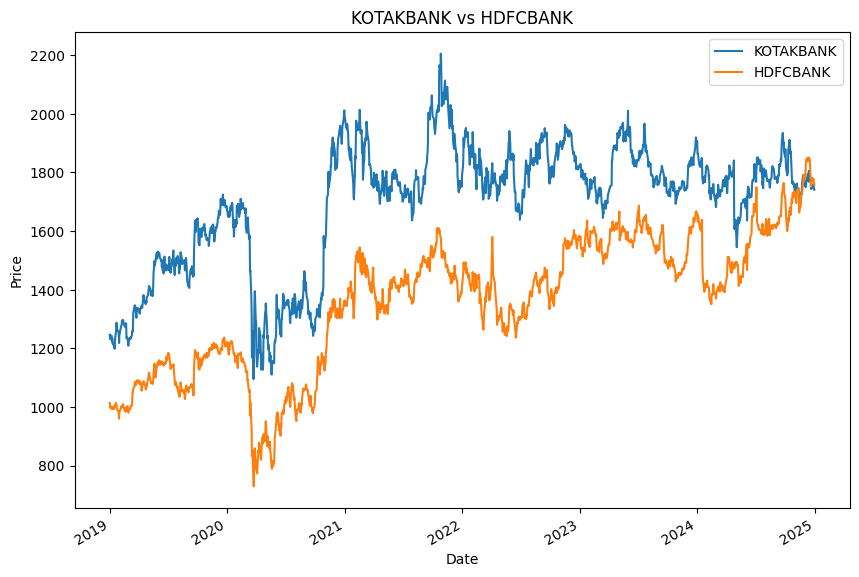

In [4]:
df.plot(figsize=(10, 7))
plt.ylabel("Price")
plt.title("KOTAKBANK vs HDFCBANK")
plt.show()

###  Step 5: Calculate Hedge Ratio using Linear Regression

We apply a simple linear regression to estimate the hedge ratio — the number of Kotak Bank shares to hold for each HDFC Bank share to create a balanced position.

In [5]:
X = df['HDFCBANK']
Y = df['KOTAKBANK']

model = np.polyfit(X, Y, deg=1)
hedge_ratio = model[0]
hr = round(hedge_ratio, 3)
print(f'The hedge ratio is {hr}')

The hedge ratio is 0.783


###  Step 6: Calculate and Plot Spread

Spread is the difference between the actual Kotak price and the estimated Kotak price based on HDFC price and hedge ratio. Mean-reverting behavior in spread is a trading opportunity.

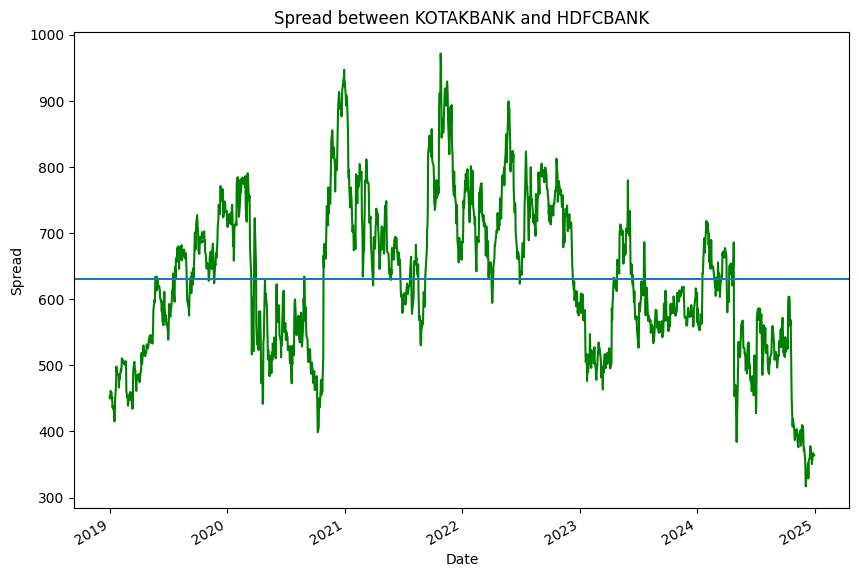

In [6]:
df['spread'] = df['KOTAKBANK'] - hr * df['HDFCBANK']
df['spread'].plot(figsize=(10, 7), color='g')
plt.axhline(df['spread'].mean())
plt.ylabel("Spread")
plt.title("Spread between KOTAKBANK and HDFCBANK")
plt.show()

###  Step 7: Perform ADF Test for Cointegration

The ADF test checks whether the spread is stationary. A stationary spread means it has a constant mean and variance — suitable for mean reversion.

In [7]:
adf_result = adfuller(df['spread'], maxlag=1)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("The spread series is likely stationary.")
else:
    print("The spread series is likely not stationary.")

ADF Statistic: -3.6473900572316023
p-value: 0.004917051390876345
Critical Values: {'1%': np.float64(-3.434779131760461), '5%': np.float64(-2.863496173799589), '10%': np.float64(-2.5678114464207265)}
The spread series is likely stationary.


###  Step 8: Define Mean Reversion Trading Strategy

This function builds trading signals:
- Enter **long** when spread is below lower band (undervalued)
- Enter **short** when spread is above upper band (overvalued)
- Exit when spread returns to mean

In [12]:
import numpy as np

def mean_reversion_strategy(df, period, std_dev):
    """
    Computes trading positions based on the spread, using a mean reversion strategy.

    Parameters:
    - df: DataFrame containing spread data
    - period: Lookback period for calculating moving average and standard deviation
    - std_dev: Number of standard deviations to use for defining upper and lower bands

    Returns:
    - DataFrame with additional columns for positions based on the mean reversion strategy
    """

    # Moving Average
    df['moving_average'] = df['spread'].rolling(period).mean()

    # Moving Standard Deviation
    df['moving_std_dev'] = df['spread'].rolling(period).std()

    # Upper and Lower Bands
    df['upper_band'] = df['moving_average'] + std_dev * df['moving_std_dev']
    df['lower_band'] = df['moving_average'] - std_dev * df['moving_std_dev']

    # Long Positions
    df['long_entry'] = df['spread'] < df['lower_band']
    df['long_exit'] = df['spread'] >= df['moving_average']
    df['positions_long'] = np.nan
    df.loc[df['long_entry'], 'positions_long'] = 1
    df.loc[df['long_exit'], 'positions_long'] = 0
    df['positions_long'] = df['positions_long'].ffill()

    # Short Positions
    df['short_entry'] = df['spread'] > df['upper_band']
    df['short_exit'] = df['spread'] <= df['moving_average']
    df['positions_short'] = np.nan
    df.loc[df['short_entry'], 'positions_short'] = -1
    df.loc[df['short_exit'], 'positions_short'] = 0
    df['positions_short'] = df['positions_short'].ffill()

    # Combined Positions
    df['positions'] = df['positions_long'] + df['positions_short']

    return df

In [13]:
df = mean_reversion_strategy(df, 30, 1)
df.dropna(inplace=True)
df.tail(3)

,KOTAKBANK,HDFCBANK,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions
Date,,,,,,,,,,,,,,
2024-12-26,1752.800049,1771.264160,365.900211,366.829673,24.800657,391.630331,342.029016,False,False,0.0,False,True,0.0,0.0
2024-12-27,1759.900024,1778.682617,367.191535,366.046433,24.388788,390.435221,341.657644,False,True,0.0,False,False,0.0,0.0
2024-12-30,1740.699951,1758.554077,363.752109,365.315561,24.107094,389.422655,341.208467,False,False,0.0,False,True,0.0,0.0


###  Step 9: Calculate Strategy Returns

We simulate strategy returns by computing daily percentage change in spread and multiplying it with the current position (1 for long, -1 for short).

In [15]:
df['percentage_change'] = (df['spread'] - df['spread'].shift(1)) / (hr * df['HDFCBANK'] + df['KOTAKBANK'])
df['strategy_returns'] = df['positions'].shift(1) * df['percentage_change']
df['cumulative_returns'] = (df['strategy_returns'] + 1).cumprod()
print("The total strategy returns are %.2f%%" % ((df['cumulative_returns'].iloc[-1] - 1) * 100))
df['strategy_returns'].head(5)

The total strategy returns are 118.27%


,strategy_returns
Date,
2019-02-11,NaN
2019-02-12,-0.000378
2019-02-14,0.002233
2019-02-15,-0.000189
2019-02-18,0.001274


###  Step 10: Compute Sharpe Ratio

We use `yfinance` to download historical stock prices for our selected stocks. If not already installed, this cell ensures the necessary package is available.

In [24]:
sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')

Sharpe Ratio: 1.162


###  Step 11: Visualize Strategy Performance

We use `yfinance` to download historical stock prices for our selected stocks. If not already installed, this cell ensures the necessary package is available.

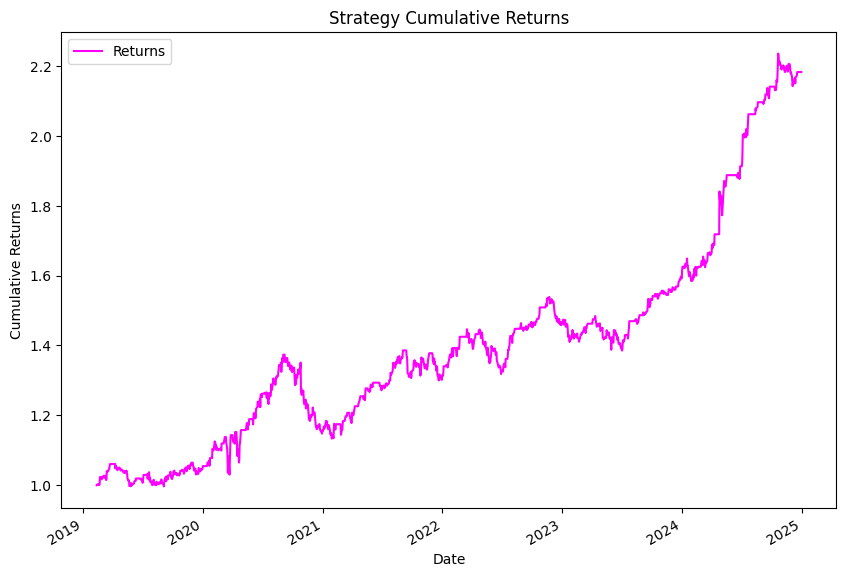

In [18]:
df['cumulative_returns'].plot(label='Returns', figsize=(10, 7), color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

###  Step 12: Drawdown Analysis

We use `yfinance` to download historical stock prices for our selected stocks. If not already installed, this cell ensures the necessary package is available.

The maximum drawdown is -17.51%


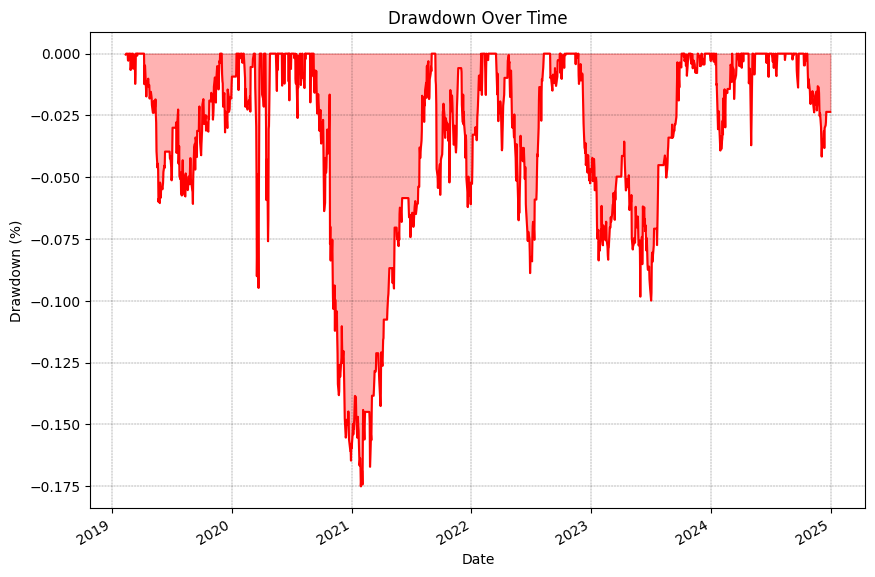

In [19]:
def calc_drawdown(cum_rets):
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1
    drawdown = cum_rets / running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.title('Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

drawdown_strategy = calc_drawdown(df['cumulative_returns'])
print("The maximum drawdown is %.2f%%" % (drawdown_strategy.min() * 100))
plot_drawdown(drawdown_strategy)

###  Step 13: Compare With Market (Nifty)

We use `yfinance` to download historical stock prices for our selected stocks. If not already installed, this cell ensures the necessary package is available.

[*********************100%***********************]  1 of 1 completed


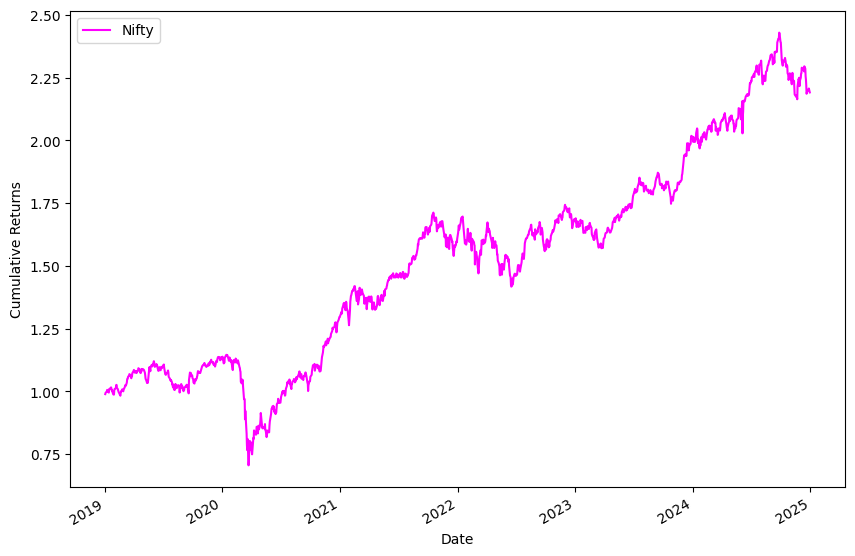

,Nifty
Date,
2019-01-02,10792.500000
2019-01-03,10672.250000
2019-01-04,10727.349609
2019-01-07,10771.799805
2019-01-08,10802.150391
...,...
2024-12-23,23753.449219
2024-12-24,23727.650391
2024-12-26,23750.199219


In [20]:
#to compare how our strategy performed , we will create an instance and compare the
start_date = '2019-01-01'
end_date = '2024-12-31'
nifty = yf.download('^NSEI', start=start_date, end=end_date)['Close']
nifty.columns = ['Nifty']
nifty_cum_rets = (nifty.pct_change().dropna()+1).cumprod()
nifty_cum_rets.plot(label='Nifty', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
nifty

In [21]:
#drawdown_nifty
drawdown_nifty = calc_drawdown(nifty_cum_rets)
print("The maximum drawdown is %.2f" % (drawdown_nifty.min()*100))

The maximum drawdown is -38.44


In [22]:
 import matplotlib.pyplot as plt
 def plot_drawdown(drawdown):
    plt.figure(figsize=(10, 5))

    # Ensure drawdown is a Pandas Series
    if isinstance(drawdown, pd.DataFrame):
        drawdown = drawdown.squeeze()  # Convert to Series
    if drawdown.ndim != 1:
        raise ValueError("Drawdown data must be 1-dimensional")
    drawdown.plot(color='r', label="Drawdown")
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown (%)')
    plt.xlabel('Date')
    plt.title('Drawdown Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

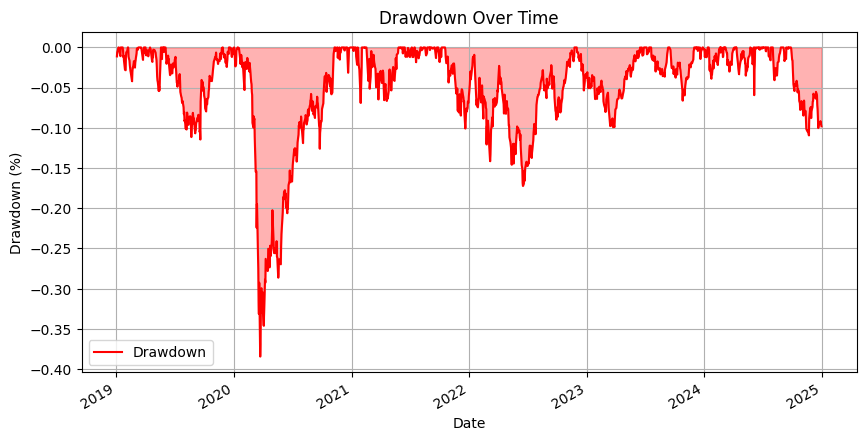

In [23]:
drawdown_nifty = calc_drawdown(nifty_cum_rets)
# Ensure it's a Series
if isinstance(drawdown_nifty, pd.DataFrame):
    drawdown_nifty = drawdown_nifty.squeeze()
plot_drawdown(drawdown_nifty)